In [1]:
import pandas as pd 
import numpy as np 
import scipy.stats  
import math
import yfinance as yf 
import matplotlib.pyplot as plt 
import seaborn as sns 
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, accuracy_score, roc_curve, roc_auc_score, auc 
from scipy.stats import randint, uniform 
from sklearn.svm import SVC 
import xgboost as xgb
import tensorflow as tf 
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Flatten
from tensorflow.keras.optimizers import Adam

C:\Users\auyin\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Data Preparation 

In [2]:
#get HSI daily data from 2013 to 2022 
hsi = yf.Ticker("^HSI").history(start="1992-01-01", end="2023-01-30", 
                                     interval="1d")

                                                 
hsi= hsi.drop(columns=["Dividends", 
                                 "Stock Splits"]).reset_index() 

#create a binary label to see whether close price > previous day 
hsi['label'] = (hsi['Close'] > hsi['Close'].shift()).astype(int).fillna(0)

hsi

,Date,Open,High,Low,Close,Volume,label
0,1992-01-02,4297.299805,4316.600098,4284.100098,4301.799805,0,0
1,1992-01-03,4301.799805,4311.799805,4294.200195,4307.100098,0,1
2,1992-01-06,4319.700195,4330.899902,4297.700195,4307.000000,0,0
3,1992-01-07,4307.000000,4356.799805,4303.500000,4347.899902,0,1
4,1992-01-08,4347.899902,4373.700195,4328.500000,4337.700195,0,0
...,...,...,...,...,...,...,...
7665,2023-01-18,21514.800781,21691.669922,21422.189453,21678.000000,2485346700,1
7666,2023-01-19,21452.259766,21754.080078,21383.029297,21650.980469,1664915500,0
7667,2023-01-20,21812.460938,22051.769531,21754.349609,22044.650391,1956241900,1
7668,2023-01-26,22386.369141,22566.779297,22329.070312,22566.779297,2455079700,1


In [3]:
import requests
from bs4 import BeautifulSoup

# Get the page
r = requests.get('https://countryeconomy.com/key-rates/hong-kong')

# Parse the HTML
soup = BeautifulSoup(r.text, 'html.parser')


#find the table 
table= soup.find('table', id= "tb0")
#find rows  
rows= table.find_all('tr')

#scrape from 2nd <tr> to last <tr> 
dates= [] 
key_rates= [] 

for row in rows[1:]: 
    dates.append(row.find_all('td')[0].text)
    key_rates.append(row.find_all('td')[1].text)

rates= pd.DataFrame(data= {
    "date": dates, 
    "interest_rate": key_rates
})

#convert date column as datetime and sort ascendingly 
rates["date"]= pd.to_datetime(rates["date"], format="%m/%d/%Y")
rates= rates.sort_values(by="date").reset_index(drop=True)

rates["interest_rate"]= pd.to_numeric(rates["interest_rate"]
                                      .str.replace("%", "")) 
rates["interest_rate"]= rates["interest_rate"] / 100

#localize time zone for dataframe merge 
#rates["date"]= rates["date"].dt.tz_localize("Asia/Hong_Kong")

hsi= pd.merge_asof(hsi, 
                   rates, 
                   left_on="Date", 
                   right_on="date", direction= "backward")

hsi= hsi.drop(columns=["date"])

In [4]:
#get data of USD/HKD exchange rate
hkd_hist= pd.read_csv('usd_hkd_historical.csv') 
hkd_hist= hkd_hist.drop(columns=["Open", "High", 
                                "Low", "Vol.", "Change %"])
hkd_hist= hkd_hist.sort_values(by="Date").reset_index(drop=True)
hkd_hist["Date"]= pd.to_datetime(hkd_hist["Date"], format="%d/%m/%Y")
hkd_hist= hkd_hist.rename(columns={
    "Price": "usd_hkd"
})


hsi= pd.merge(hsi, hkd_hist, on="Date")

In [5]:
#create a function to calculate Relative Strength Index (RSI)
def RSI(df, n=14):
    # Create a new column with the difference between the current and previous close price
    df['delta'] = df['Close'].diff()

    # Create columns for gains and losses
    df['gain'] = np.where(df['delta'] > 0, df['delta'], 0)
    df['loss'] = np.where(df['delta'] < 0, abs(df['delta']), 0)

    # Calculate the average gain and loss over the period
    avg_gain = df['gain'].rolling(n).mean()
    avg_loss = df['loss'].rolling(n).mean()

    # Calculate the relative strength
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))

    # Create a new "RSI" column
    df['RSI'] = rsi
    df= df.drop(columns=["delta", "gain", "loss"])
    df["RSI"]= df["RSI"].fillna(0) 
    return df

hsi= RSI(hsi)

In [6]:
#create a function to calculate MACD 
def MACD(df): 
    #calculate the 26-day and 12-day exponential moving averages 
    ema_26= df["Close"].ewm(span=26).mean() 
    ema_12= df["Close"].ewm(span=12).mean() 
    
    #create a new "MACD" column 
    macd= ema_12 - ema_26 
    df["MACD"]= macd 
    return df 

hsi= MACD(hsi)

In [7]:
hsi.isnull().sum() 

Date              0
Open              0
High              0
Low               0
Close             0
Volume            0
label             0
interest_rate    82
usd_hkd           0
RSI               0
MACD              0
dtype: int64

In [8]:
#ignore first 73 rows because of missing values 
hsi= hsi.iloc[82:, :].reset_index(drop=True)
hsi

,Date,Open,High,Low,Close,Volume,label,interest_rate,usd_hkd,RSI,MACD
0,1992-06-01,6099.399902,6161.200195,6044.600098,6056.000000,0,0,0.0450,7.7395,72.439434,193.750426
1,1992-06-02,6058.500000,6081.500000,5999.899902,6059.399902,0,1,0.0450,7.7390,70.604317,191.058054
2,1992-06-03,6057.600098,6057.600098,5996.899902,6037.399902,0,0,0.0450,7.7380,69.605064,185.018276
3,1992-06-04,6012.000000,6067.700195,5979.700195,6035.799805,0,0,0.0450,7.7365,73.613671,178.049953
4,1992-06-08,6026.100098,6039.899902,5978.100098,5978.799805,0,0,0.0450,7.7365,74.721434,166.019300
...,...,...,...,...,...,...,...,...,...,...,...
7563,2023-01-18,21514.800781,21691.669922,21422.189453,21678.000000,2485346700,1,0.0475,7.8246,83.346195,761.262588
7564,2023-01-19,21452.259766,21754.080078,21383.029297,21650.980469,1664915500,0,0.0475,7.8299,87.641873,739.930428
7565,2023-01-20,21812.460938,22051.769531,21754.349609,22044.650391,1956241900,1,0.0475,7.8289,89.152939,746.188811
7566,2023-01-26,22386.369141,22566.779297,22329.070312,22566.779297,2455079700,1,0.0475,7.8280,89.716017,784.239835


# EDA (exploratory data analysis)

In [9]:
hsi.describe()

,Open,High,Low,Close,Volume,label,interest_rate,usd_hkd,RSI,MACD
count,7568.000000,7568.000000,7568.000000,7568.000000,7.568000e+03,7568.000000,7568.000000,7568.000000,7568.000000,7568.000000
mean,17731.509380,17847.954656,17591.870823,17724.086850,1.066874e+09,0.516649,0.032580,7.772368,52.392374,13.646127
std,6750.226284,6777.267039,6708.025081,6742.089791,1.070195e+09,0.499756,0.024725,0.031791,17.838673,301.595940
min,5166.600098,5202.399902,4947.799805,4978.200195,0.000000e+00,0.000000,0.005000,7.703700,5.551867,-1666.971215
25%,11486.625244,11583.642334,11361.687256,11471.449951,0.000000e+00,0.000000,0.005000,7.750100,39.678482,-139.194216
50%,18005.200195,18145.944336,17822.520508,18010.629883,1.067241e+09,1.000000,0.027500,7.762500,51.993381,43.507315
75%,23213.639648,23326.201660,23068.884766,23190.660645,1.784326e+09,1.000000,0.060000,7.798800,65.588292,190.659351
max,33335.480469,33484.078125,32897.039062,33154.121094,9.799120e+09,1.000000,0.080000,7.850100,100.000000,1380.859080


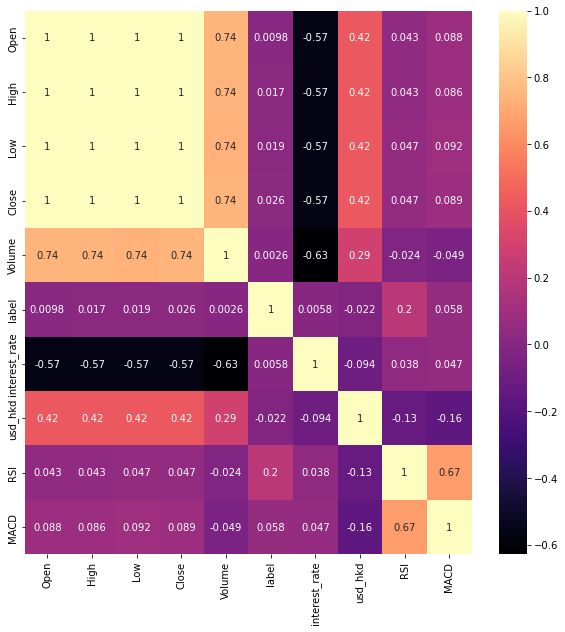

In [10]:
corr_matrix= hsi.corr()
fig, ax = plt.subplots(figsize=(10,10)) 
sns.heatmap(corr_matrix, annot= True, cmap='magma')
plt.show() 

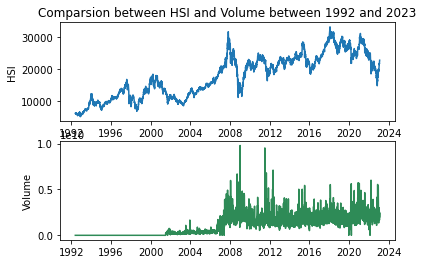

In [11]:
#plot HSI close and volume 
fig, (ax1, ax2) = plt.subplots(2,1)

ax1.plot(hsi["Date"], hsi["Close"])
ax1.set_ylabel("HSI")
ax1.set_title('Comparsion between HSI and Volume between 1992 and 2023') 

ax2.plot(hsi["Date"], hsi["Volume"], color= "seagreen")
ax2.set_ylabel("Volume")

plt.show()

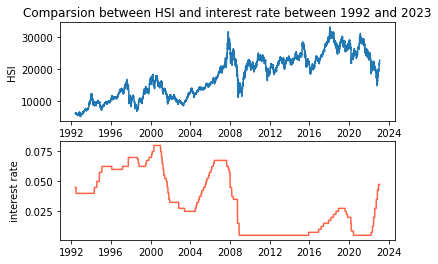

In [12]:
#plot HSI close and interest rate 
fig, (ax1, ax2) = plt.subplots(2,1)

ax1.plot(hsi["Date"], hsi["Close"])
ax1.set_ylabel("HSI")
ax1.set_title('Comparsion between HSI and interest rate between 1992 and 2023') 

ax2.plot(hsi["Date"], hsi["interest_rate"], color= "tomato")
ax2.set_ylabel("interest rate")

plt.show()

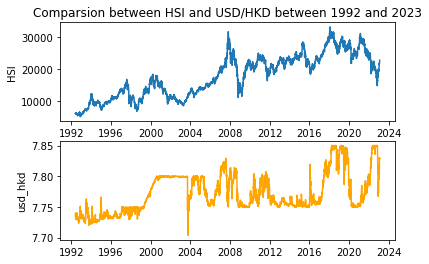

In [13]:
#plot HSI Close and USD/HKD exchange rate 
fig, (ax1, ax2) = plt.subplots(2,1)

ax1.plot(hsi["Date"], hsi["Close"])
ax1.set_ylabel("HSI")
ax1.set_title('Comparsion between HSI and USD/HKD between 1992 and 2023') 

ax2.plot(hsi["Date"], hsi["usd_hkd"], color= "orange")
ax2.set_ylabel("usd_hkd")

plt.show()

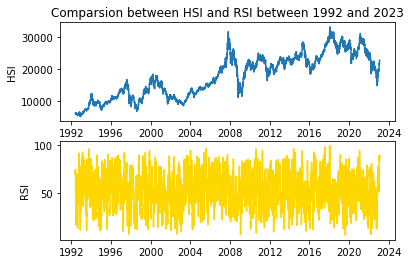

In [14]:
#plot HSI Close and RSI 
fig, (ax1, ax2) = plt.subplots(2,1)

ax1.plot(hsi["Date"], hsi["Close"])
ax1.set_ylabel("HSI")
ax1.set_title('Comparsion between HSI and RSI between 1992 and 2023') 

ax2.plot(hsi["Date"], hsi["RSI"], color= "gold")
ax2.set_ylabel("RSI")

plt.show()

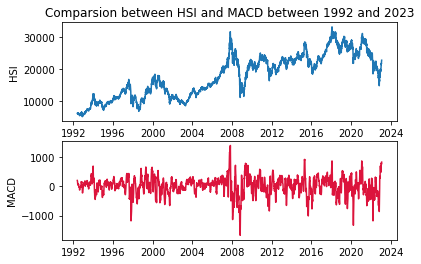

In [15]:
#plot HSI Close and MACD 
fig, (ax1, ax2) = plt.subplots(2,1)

ax1.plot(hsi["Date"], hsi["Close"])
ax1.set_ylabel("HSI")
ax1.set_title('Comparsion between HSI and MACD between 1992 and 2023') 

ax2.plot(hsi["Date"], hsi["MACD"], color= "crimson")
ax2.set_ylabel("MACD")

plt.show()

# XGBoost 

##### Data preprocessing

In [16]:
X1= hsi.drop(columns=["Date","label"])
y1= hsi.label

X1_train, X1_test, y1_train, y1_test= train_test_split(X1, 
                                                       y1, 
                                                       test_size=0.2,
                                                       random_state=42)

scaler = StandardScaler()
X1_train_scaled = scaler.fit_transform(X1_train)
X1_test_scaled = scaler.transform(X1_test)

##### Hyperparameter Tuning 

In [17]:
def best_hyperparams_xgb(X_train, y_train, n_iter=100, cv=5, random_state=42):
    """
    Find the best hyperparameters for the XGBoost model using random search cross-validation.
    
    Returns:
    best_params (dict): The best hyperparameters found during the search.    
    """
    
    # Define the parameters range for the random search
    params = {
        'max_depth': randint(3, 10),
        'min_child_weight': randint(1, 6),
        'subsample': [0.6, 0.7, 0.8, 0.9],
        'colsample_bytree': [0.6, 0.7, 0.8, 0.9],
        'gamma': [0, 0.1, 0.2, 0.3, 0.4],
        'reg_alpha': [0, 0.1, 0.5, 1],
        'reg_lambda': [0, 0.1, 0.5, 1],
        'learning_rate': [0.01, 0.1, 0.2, 0.3]
    }
    
    xgb_clf = xgb.XGBClassifier(objective='binary:logistic', 
                                random_state=random_state, 
                                eval_metric='auc')
    
    random_search = RandomizedSearchCV(xgb_clf, 
                                       param_distributions=params, 
                                       n_iter=n_iter,
                                       cv=cv,
                                       n_jobs=-1, 
                                       random_state=random_state)
    random_search.fit(X_train, y_train)
    
    # Get the best hyperparameters and cross-validation results
    best_params = random_search.best_params_
    
    return best_params

In [18]:
best_hyperparams_xgb(X1_train_scaled, y1_train)

{'colsample_bytree': 0.9,
 'gamma': 0.1,
 'learning_rate': 0.3,
 'max_depth': 6,
 'min_child_weight': 5,
 'reg_alpha': 0.5,
 'reg_lambda': 0,
 'subsample': 0.8}

##### Model Training 

In [19]:
params = {
    'objective': 'binary:logistic',
    'colsample_bytree': 0.9, 
    'gamma': 0.1,
    'learning_rate': 0.3,
    'max_depth': 6,
    'min_child_weight': 5,
    'reg_alpha': 0.5,
    'reg_lambda': 0,
    'subsample': 0.8,
    'eval_metric': 'auc',
    'seed': 42,
}

# Convert data to DMatrix 
dtrain = xgb.DMatrix(X1_train_scaled, y1_train, feature_names=X1.columns) 
dtest= xgb.DMatrix(X1_test_scaled, y1_test, feature_names=X1.columns)

# Perform cross-validation with XGBoost
cv_results = xgb.cv(params=params,
                    dtrain=dtrain,
                    num_boost_round=1000,
                    nfold=5,
                    metrics='auc',
                    early_stopping_rounds=50,
                    verbose_eval=True,
                    shuffle=True,
                    seed=42)


[0]	train-auc:0.66825+0.00280	test-auc:0.60771+0.00676
[1]	train-auc:0.69546+0.00467	test-auc:0.61735+0.00685
[2]	train-auc:0.70953+0.00610	test-auc:0.62203+0.00842
[3]	train-auc:0.71883+0.00429	test-auc:0.62595+0.00850
[4]	train-auc:0.72903+0.00312	test-auc:0.62622+0.01040
[5]	train-auc:0.74082+0.00860	test-auc:0.62843+0.00888
[6]	train-auc:0.75248+0.00856	test-auc:0.62917+0.00900
[7]	train-auc:0.75992+0.00761	test-auc:0.63123+0.00892
[8]	train-auc:0.77066+0.00657	test-auc:0.63512+0.00843
[9]	train-auc:0.77993+0.00550	test-auc:0.63843+0.00265
[10]	train-auc:0.78655+0.00392	test-auc:0.63891+0.00363
[11]	train-auc:0.79361+0.00461	test-auc:0.64498+0.00625
[12]	train-auc:0.79877+0.00536	test-auc:0.64292+0.00737
[13]	train-auc:0.80308+0.00479	test-auc:0.64460+0.00647
[14]	train-auc:0.81054+0.00415	test-auc:0.64735+0.00597
[15]	train-auc:0.81745+0.00373	test-auc:0.65170+0.00506
[16]	train-auc:0.82566+0.00380	test-auc:0.65446+0.00451
[17]	train-auc:0.83236+0.00380	test-auc:0.65882+0.00525
[1

In [20]:
cv_results['train-auc-mean'].max() 

0.998487802350421

In [21]:
print(f"The {cv_results['test-auc-mean'].idxmax()+1}th iteration has the highest test accuracy of {cv_results['test-auc-mean'].max():.4f}")

The 237th iteration has the highest test accuracy of 0.7576


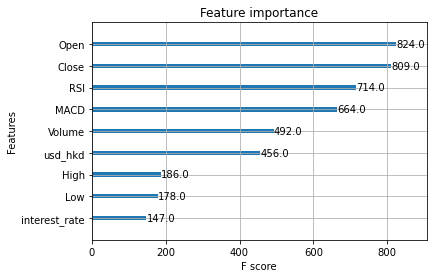

In [22]:
best_iteration =  cv_results['train-auc-mean'].idxmax() + 1

xgb_clf= xgb.train(params=params,
                   dtrain=dtrain,
                   num_boost_round=best_iteration)

xgb.plot_importance(xgb_clf) 
plt.show()

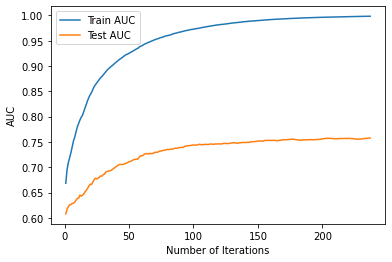

In [23]:
# Plot the train and test AUC values after cross-validation
train_auc = cv_results['train-auc-mean']
test_auc = cv_results['test-auc-mean']
num_rounds = len(train_auc)

fig, ax = plt.subplots()
ax.plot(range(1, num_rounds + 1), train_auc, label='Train AUC')
ax.plot(range(1, num_rounds + 1), test_auc, label='Test AUC')
ax.set_xlabel('Number of Iterations')
ax.set_ylabel('AUC')
ax.legend()
plt.show()

In [24]:
#separate target and features for 1st model 
X2= hsi[["Open","Close"]]
y2= hsi.label

#split data into training and test sets for the 1st model 
X2_train, X2_test, y2_train, y2_test= train_test_split(X2,
                                                       y2, 
                                                       test_size=0.2,
                                                       random_state=42)


scaler = StandardScaler()
X2_train_scaled = scaler.fit_transform(X2_train)
X2_test_scaled = scaler.transform(X2_test)

In [25]:
best_hyperparams_xgb(X2_train_scaled, y2_train)

{'colsample_bytree': 0.7,
 'gamma': 0.2,
 'learning_rate': 0.3,
 'max_depth': 8,
 'min_child_weight': 1,
 'reg_alpha': 0.5,
 'reg_lambda': 0,
 'subsample': 0.6}

In [26]:
params2 = {
    'objective': 'binary:logistic',
    'colsample_bytree': 0.7, 
    'gamma': 0.2,
    'learning_rate': 0.3,
    'max_depth': 8,
    'min_child_weight': 1,
    'reg_alpha': 0.5,
    'reg_lambda': 0,
    'subsample': 0.6,
    'eval_metric': 'auc',
    'seed': 42
}

dtrain2 = xgb.DMatrix(X2_train_scaled, y2_train) 
dtest2= xgb.DMatrix(X2_test_scaled, y2_test)

# Perform cross-validation with XGBoost
cv_results2 = xgb.cv(params=params2,
                     dtrain=dtrain2,
                     num_boost_round=400,
                     nfold=5,
                     metrics='auc',
                     verbose_eval=True,
                     shuffle=True,
                     seed=42)

[0]	train-auc:0.55379+0.01403	test-auc:0.49279+0.00964
[1]	train-auc:0.58797+0.00931	test-auc:0.48988+0.01231
[2]	train-auc:0.60708+0.00895	test-auc:0.48630+0.01216
[3]	train-auc:0.62181+0.01656	test-auc:0.48612+0.00717
[4]	train-auc:0.63599+0.01526	test-auc:0.49149+0.00639
[5]	train-auc:0.64741+0.01790	test-auc:0.49209+0.00418
[6]	train-auc:0.66195+0.02210	test-auc:0.49469+0.00453
[7]	train-auc:0.67708+0.01580	test-auc:0.49880+0.00877
[8]	train-auc:0.68414+0.01675	test-auc:0.49979+0.00969
[9]	train-auc:0.69142+0.01750	test-auc:0.49847+0.01221
[10]	train-auc:0.70059+0.01747	test-auc:0.49802+0.01305
[11]	train-auc:0.70613+0.01419	test-auc:0.49593+0.01112
[12]	train-auc:0.71408+0.01498	test-auc:0.49319+0.00947
[13]	train-auc:0.72178+0.01378	test-auc:0.49361+0.01194
[14]	train-auc:0.72867+0.01333	test-auc:0.49592+0.01284
[15]	train-auc:0.73554+0.00930	test-auc:0.49691+0.01533
[16]	train-auc:0.74273+0.00859	test-auc:0.49828+0.01477
[17]	train-auc:0.74723+0.00885	test-auc:0.50030+0.01303
[1

In [27]:
print(f"The {cv_results2['test-auc-mean'].idxmax()+1}th iteration has the highest test accuracy of {cv_results2['test-auc-mean'].max():.4f}")

The 398th iteration has the highest test accuracy of 0.5169


In [28]:
cv_results2['train-auc-mean'].max() 

0.9957993084146383

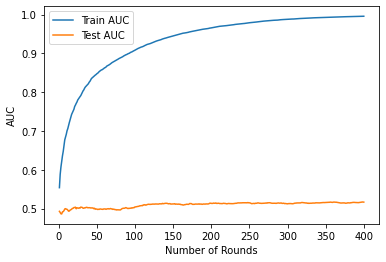

In [29]:
# Plot the train and test AUC values after cross-validation
train_auc = cv_results2['train-auc-mean']
test_auc = cv_results2['test-auc-mean']
num_rounds = len(train_auc)

fig, ax = plt.subplots()
ax.plot(range(1, num_rounds + 1), train_auc, label='Train AUC')
ax.plot(range(1, num_rounds + 1), test_auc, label='Test AUC')
ax.set_xlabel('Number of Rounds')
ax.set_ylabel('AUC')
ax.legend()
plt.show()

<b> Overfitting occurs

In [30]:
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X2_train_scaled)
X_test_pca = pca.transform(X2_test_scaled)

pd.DataFrame(X_train_pca)

,0,1
0,1.126905,-0.007047
1,-0.342844,0.016212
2,-0.607049,-0.002961
3,2.179908,0.020073
4,2.281493,-0.009388
...,...,...
6049,0.951364,-0.002280
6050,0.863709,0.004376
6051,0.835589,-0.003024
6052,-1.764273,0.000894


In [31]:
best_hyperparams_xgb(X_train_pca, y2_train)

{'colsample_bytree': 0.9,
 'gamma': 0.2,
 'learning_rate': 0.01,
 'max_depth': 3,
 'min_child_weight': 4,
 'reg_alpha': 0.5,
 'reg_lambda': 0.5,
 'subsample': 0.7}

In [32]:
params3= {'colsample_bytree': 0.9,
 'gamma': 0.2,
 'learning_rate': 0.01,
 'max_depth': 3,
 'min_child_weight': 4,
 'reg_alpha': 0.5,
 'reg_lambda': 0.5,
 'subsample': 0.7, 
 'eval_metric': 'auc', 
 'seed': 42
}

dtrain_pca = xgb.DMatrix(X_train_pca, y2_train)

cv_results_pca = xgb.cv(params=params3,
                        dtrain=dtrain_pca,
                        num_boost_round=100,
                        nfold=5,
                        metrics='auc',
                        early_stopping_rounds=50, 
                        verbose_eval=True,
                        shuffle=True,
                        seed=42)

[0]	train-auc:0.51984+0.00635	test-auc:0.49934+0.00665
[1]	train-auc:0.73282+0.16998	test-auc:0.72350+0.18300
[2]	train-auc:0.73586+0.16676	test-auc:0.72386+0.17899
[3]	train-auc:0.80252+0.13738	test-auc:0.79464+0.14481
[4]	train-auc:0.80567+0.13770	test-auc:0.79936+0.14626
[5]	train-auc:0.80775+0.13435	test-auc:0.79752+0.15054
[6]	train-auc:0.81000+0.13091	test-auc:0.79673+0.15162
[7]	train-auc:0.81064+0.13032	test-auc:0.79685+0.15282
[8]	train-auc:0.81093+0.13005	test-auc:0.79760+0.15220
[9]	train-auc:0.87531+0.00242	test-auc:0.86541+0.01832
[10]	train-auc:0.87700+0.00173	test-auc:0.86911+0.01213
[11]	train-auc:0.87682+0.00167	test-auc:0.86892+0.01250
[12]	train-auc:0.87685+0.00147	test-auc:0.86863+0.01263
[13]	train-auc:0.87752+0.00213	test-auc:0.86992+0.01051
[14]	train-auc:0.87752+0.00198	test-auc:0.86969+0.01114
[15]	train-auc:0.87775+0.00216	test-auc:0.87041+0.00985
[16]	train-auc:0.87781+0.00213	test-auc:0.87023+0.01007
[17]	train-auc:0.87784+0.00209	test-auc:0.86988+0.01043
[1

In [33]:
print(f"The {cv_results_pca['test-auc-mean'].idxmax()+1}th iteration has the highest test accuracy of {cv_results_pca['test-auc-mean'].max():.4f}")

The 56th iteration has the highest test accuracy of 0.8722


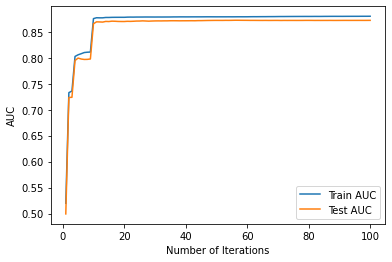

In [34]:
# Plot the train and test AUC values after cross-validation
train_auc_pca = cv_results_pca['train-auc-mean']
test_auc_pca = cv_results_pca['test-auc-mean']
num_rounds_pca = len(train_auc_pca)

fig, ax = plt.subplots()
ax.plot(range(1, num_rounds_pca + 1), train_auc_pca, label='Train AUC')
ax.plot(range(1, num_rounds_pca + 1), test_auc_pca, label='Test AUC')
ax.set_xlabel('Number of Iterations')
ax.set_ylabel('AUC')
ax.legend()
plt.show()

In [35]:
best_iteration =  cv_results_pca['train-auc-mean'].idxmax() + 1

# Train the model with the best iteration according to cv results 
xgb_clf = xgb.train(params=params,
                    dtrain=dtrain_pca,
                    num_boost_round=best_iteration)

dtest = xgb.DMatrix(X_test_pca)


y_xgb_pred= xgb_clf.predict(dtest)

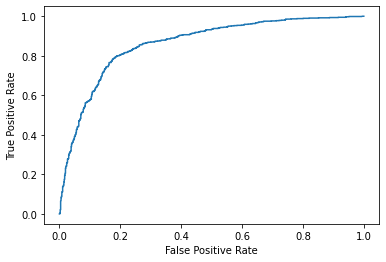

In [36]:
fpr, tpr, thresholds = roc_curve(y2_test, y_xgb_pred, pos_label=1)

plt.plot(fpr, tpr) 
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.show()

# SVM

In [37]:
def f_importances(coef, names):
    imp = coef.flatten() 
    imp,names = zip(*sorted(zip(imp,names)))
    plt.barh(range(len(names)), imp, align='center')
    plt.yticks(range(len(names)), names)
    plt.xlabel('model coefficient')
    plt.show()

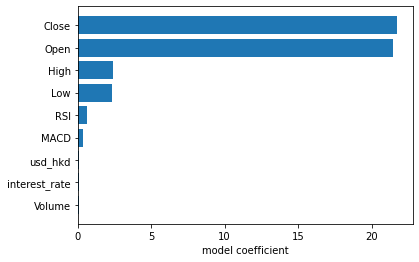

In [38]:
feature_names= X1.columns.to_list() 
svc_f_importance = SVC(kernel='linear')
svc_f_importance.fit(X1_train_scaled, y1_train)
f_importances(abs(svc_f_importance.coef_[0]), feature_names)

In [39]:
def best_params_svc(X_train, y_train):
    param_list = {'C': uniform(0.1, 9.9), 
                  'kernel': ['linear', 'rbf', 'poly'], 
                  'gamma': uniform(0.001, 0.099)}

    clf = SVC()

    randomized_search = RandomizedSearchCV(clf, 
                                           param_list, 
                                           n_iter=10, 
                                           cv=5)
    
    randomized_search.fit(X_train, y_train)

    print(f"Best hyperparameters: {randomized_search.best_params_}")
    print(f"Best accuracy score: {randomized_search.best_score_:.4f}")

In [40]:
best_params_svc(X2_train_scaled, y2_train) 

Best hyperparameters: {'C': 9.61999648975704, 'gamma': 0.07329409010142894, 'kernel': 'linear'}
Best accuracy score: 0.8059


In [41]:
svc_clf = SVC(C=8.934936828930883, 
              gamma=0.0715685198767052, 
              kernel="linear") 
svc_clf.fit(X2_train_scaled, y2_train)

test_pred_svc = svc_clf.predict(X2_test_scaled)
test_accuracy = accuracy_score(y2_test, test_pred_svc)
print(f"Test accuracy of SVM without PCA: {test_accuracy:.4f}")

Test accuracy of SVM without PCA: 0.8177


Do PCA to test whether the model accuracy can be improved 

In [42]:
best_params_svc(X_train_pca, y2_train) 

Best hyperparameters: {'C': 4.932958985577058, 'gamma': 0.01418503044108482, 'kernel': 'linear'}
Best accuracy score: 0.8054


In [43]:
svc_clf_pca = SVC(C=4.932958985577058,  
              gamma=0.01418503044108482, 
              kernel='linear') 

svc_clf_pca.fit(X_train_pca, y2_train)
svc_pred = svc_clf_pca.predict(X_test_pca)
test_accuracy = accuracy_score(y2_test, svc_pred)
print(f'Test accuracy: {test_accuracy:.4f}')

Test accuracy: 0.8104


In [44]:
print(svc_clf.coef_) 
print(svc_clf.intercept_)

[[-52.25277992  52.28776573]]
[0.10853478]


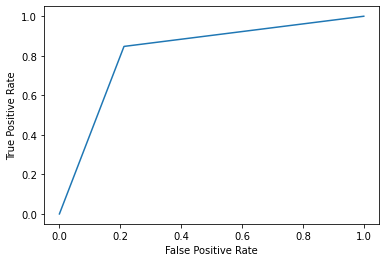

In [45]:
fpr2, tpr2, thresholds2 = roc_curve(y2_test, test_pred_svc, pos_label=1)

plt.plot(fpr2, tpr2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

# LSTM model 

In [46]:
X1_lstm= hsi[["Open","Close"]].to_numpy() 
y1_lstm= hsi.label.to_numpy() 


X1_lstm_train, X1_lstm_test, y1_lstm_train, y1_lstm_test= train_test_split(X1_lstm, 
                                                                           y1_lstm, 
                                                                           test_size=0.2,
                                                                           random_state=42)

X1_lstm_train, X1_lstm_val, y1_lstm_train, y1_lstm_val= train_test_split(X1_lstm_train, 
                                                                         y1_lstm_train, 
                                                                         test_size=0.2,
                                                                         random_state=42)

scaler = StandardScaler()
X1_lstm_train_scaled = scaler.fit_transform(X1_lstm_train)
X1_lstm_test_scaled = scaler.transform(X1_lstm_test)
X1_lstm_val_scaled= scaler.transform(X1_lstm_val)

In [47]:
print(X1_lstm_train.shape) 
print(y1_lstm_train.shape)

(4843, 2)
(4843,)


In [48]:
# Reshape the data for LSTM input
X1_lstm_train_scaled = np.reshape(X1_lstm_train_scaled, (X1_lstm_train_scaled.shape[0], X1_lstm_train_scaled.shape[1], 1))
X1_lstm_val_scaled = np.reshape(X1_lstm_val_scaled, (X1_lstm_val_scaled.shape[0], X1_lstm_val_scaled.shape[1], 1))
X1_lstm_test_scaled = np.reshape(X1_lstm_test_scaled, (X1_lstm_test_scaled.shape[0], X1_lstm_test_scaled.shape[1], 1))

model = Sequential()
model.add(LSTM(128, input_shape=(X1_lstm_train_scaled.shape[1], 1)))
model.add(Dense(1, activation='tanh'))  

optimizer = Adam(learning_rate=0.01) 
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

history = model.fit(
    X1_lstm_train_scaled, 
    y1_lstm_train, 
    validation_data=(X1_lstm_val_scaled, y1_lstm_val), 
    epochs=100, 
    batch_size=100)

Epoch 1/100
49/49 [==============================] - 2s 11ms/step - loss: 0.9899 - accuracy: 0.5073 - val_loss: 0.6937 - val_accuracy: 0.5103
Epoch 2/100
49/49 [==============================] - 0s 4ms/step - loss: 0.6921 - accuracy: 0.5174 - val_loss: 0.6990 - val_accuracy: 0.5103
Epoch 3/100
49/49 [==============================] - 0s 4ms/step - loss: 0.6925 - accuracy: 0.5181 - val_loss: 0.6927 - val_accuracy: 0.5070
Epoch 4/100
49/49 [==============================] - 0s 4ms/step - loss: 0.6922 - accuracy: 0.5197 - val_loss: 0.6941 - val_accuracy: 0.5103
Epoch 5/100
49/49 [==============================] - 0s 4ms/step - loss: 0.6940 - accuracy: 0.5113 - val_loss: 0.6918 - val_accuracy: 0.5103
Epoch 6/100
49/49 [==============================] - 0s 4ms/step - loss: 0.6919 - accuracy: 0.5278 - val_loss: 0.6916 - val_accuracy: 0.5120
Epoch 7/100
49/49 [==============================] - 0s 4ms/step - loss: 0.6929 - accuracy: 0.5210 - val_loss: 0.6916 - val_accuracy: 0.5310
Epoch 8/100


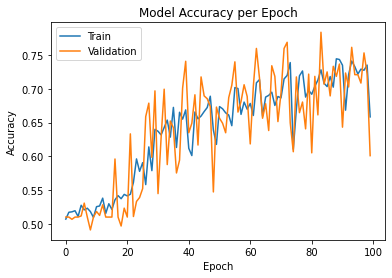

In [49]:
# Plot the accuracy per epoch for the training and validation sets
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [50]:
model.summary() 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               66560     
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 66,689
Trainable params: 66,689
Non-trainable params: 0
_________________________________________________________________
